# configuration and training

In [ ]:
!nvidia-smi

Fri Jun  4 05:12:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image
from torchvision import models
import numpy as np
from torch.nn import init
from torch import optim
from tqdm import trange,tqdm
import matplotlib
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=1, mask_suffix=''):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        self.mask_suffix = mask_suffix
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.ids = [file for file in listdir(imgs_dir)]
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx)
        img_file = glob(self.imgs_dir + idx)
        # print(self.masks_dir + idx)

        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        mask = mask.convert("L")
        img = Image.open(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'
        # mask = np.asarray(list(mask.getdata()))

        img = self.preprocess(img, self.scale)
        mask = self.preprocess(mask, self.scale)
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor)
        }


class CarvanaDataset(BasicDataset):
    def __init__(self, imgs_dir, masks_dir, scale=1):
        super().__init__(imgs_dir, masks_dir, scale, mask_suffix='_mask')

In [ ]:
dir_img = './drive/MyDrive/Dataset/CVC-ClinicDB/Original/'
dir_mask = './drive/MyDrive/Dataset/CVC-ClinicDB/Ground-Truth/'
img_scale = 1
batch_size= 10
val_percent = 0.1
lr = 0.001
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
dataset = BasicDataset(dir_img, dir_mask, img_scale)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [ ]:

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False, drop_last=True)

## filter sizes

In [ ]:
class UNet_3Plus(nn.Module):

    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True):
        super(UNet_3Plus, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        filters = [16, 32, 64, 128, 256]

        ## -------------Encoder--------------
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 5
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''
        # h1->320*320, hd4->40*40, Pooling 8 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
        self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu4d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''
        # h1->320*320, hd3->80*80, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
        self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        # h1->320*320, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 1d'''
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd1->320*320, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd1->320*320, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd1->320*320, Upsample 16 times
        self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)

        # output
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        h4 = self.conv4(h4)  # h4->40*40*512

        h5 = self.maxpool4(h4)
        hd5 = self.conv5(h5)  # h5->20*20*1024

        ## -------------Decoder-------------
        h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
        hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
            torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
            torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
            torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
            torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels

        d1 = self.outconv1(hd1)  # d1->320*320*n_classes
        return F.sigmoid(d1)

In [ ]:
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x


In [ ]:
class unetUp_origin(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp_origin, self).__init__()
        # self.conv = unetConv2(out_size*2, out_size, False)
        if is_deconv:
            self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs0, *input):
        # print(self.n_concat)
        # print(input)
        outputs0 = self.up(inputs0)
        for i in range(len(input)):
            outputs0 = torch.cat([outputs0, input[i]], 1)
        return self.conv(outputs0)


In [ ]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)


In [ ]:
def BCE_loss(pred,label):
    bce_loss = nn.BCELoss(size_average=True)
    bce_out = bce_loss(pred, label)
    print("bce_loss:", bce_out.data.cpu().numpy())
    return bce_out

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

def Dice_loss(pred,label):
  dice_loss = DiceLoss()
  dice_out = dice_loss(pred,label)
  print("\ndice_loss",dice_out.data.cpu().numpy())
  return dice_out


In [ ]:
from torchsummary import summary
net = UNet_3Plus(in_channels=3, n_classes=1).to(device=device)
summary(net,input_size=(3,384,288), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 16, 384, 288]             448
       BatchNorm2d-2          [1, 16, 384, 288]              32
              ReLU-3          [1, 16, 384, 288]               0
            Conv2d-4          [1, 16, 384, 288]           2,320
       BatchNorm2d-5          [1, 16, 384, 288]              32
              ReLU-6          [1, 16, 384, 288]               0
         unetConv2-7          [1, 16, 384, 288]               0
         MaxPool2d-8          [1, 16, 192, 144]               0
            Conv2d-9          [1, 32, 192, 144]           4,640
      BatchNorm2d-10          [1, 32, 192, 144]              64
             ReLU-11          [1, 32, 192, 144]               0
           Conv2d-12          [1, 32, 192, 144]           9,248
      BatchNorm2d-13          [1, 32, 192, 144]              64
             ReLU-14          [1, 32, 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## U-net3p

In [ ]:
optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
for epoch in trange(epochs):
  epoch_loss = 0
  step = 0
  for batch in tqdm(train_loader):
    imgs = batch['image'].to(device=device)
    true_masks = batch['mask']
    true_masks = true_masks.to(device=device, dtype=torch.float32)
    masks_pred = net(imgs)
    
    # loss = Dice_loss(masks_pred,true_masks)
    loss = BCE_loss(masks_pred,true_masks)
    epoch_loss += loss.item()
    step += 1
    if step % batch_size == 0:
      print(f'\nloss:{loss.item()} mean_loss:{epoch_loss/step}') 
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(net.parameters(), 0.1)
    optimizer.step()
  torch.save(net.state_dict(), f'/content/drive/MyDrive/Dataset/CVC-ClinicDB/Result_models/U-net3p_lr{lr}_batch_size{batch_size}_epoch{epoch}.pth')

  0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


bce_loss: 0.8057657



  2%|▏         | 1/56 [00:00<00:45,  1.21it/s]

bce_loss: 0.29764083



  4%|▎         | 2/56 [00:01<00:44,  1.21it/s]

bce_loss: 0.6508856



  5%|▌         | 3/56 [00:02<00:43,  1.22it/s]

bce_loss: 0.41192177



  7%|▋         | 4/56 [00:03<00:42,  1.23it/s]

bce_loss: 0.21221219



  9%|▉         | 5/56 [00:04<00:41,  1.23it/s]

bce_loss: 0.2795909



 11%|█         | 6/56 [00:04<00:40,  1.23it/s]

bce_loss: 0.33003777



 12%|█▎        | 7/56 [00:05<00:39,  1.24it/s]

bce_loss: 0.39875504



 14%|█▍        | 8/56 [00:06<00:38,  1.24it/s]

bce_loss: 0.29317856



 16%|█▌        | 9/56 [00:07<00:37,  1.24it/s]

bce_loss: 0.26177892

loss:0.26177892088890076 mean_loss:0.39417672604322435



 18%|█▊        | 10/56 [00:08<00:44,  1.03it/s]

bce_loss: 0.24940872



 20%|█▉        | 11/56 [00:09<00:41,  1.09it/s]

bce_loss: 0.26304987



 21%|██▏       | 12/56 [00:10<00:38,  1.13it/s]

bce_loss: 0.19722623



 23%|██▎       | 13/56 [00:11<00:37,  1.16it/s]

bce_loss: 0.42321366



 25%|██▌       | 14/56 [00:11<00:35,  1.18it/s]

bce_loss: 0.19214986



 27%|██▋       | 15/56 [00:12<00:34,  1.20it/s]

bce_loss: 0.18882261



 29%|██▊       | 16/56 [00:13<00:33,  1.21it/s]

bce_loss: 0.3958616



 30%|███       | 17/56 [00:14<00:31,  1.22it/s]

bce_loss: 0.15447325



 32%|███▏      | 18/56 [00:15<00:30,  1.23it/s]

bce_loss: 0.33251432



 34%|███▍      | 19/56 [00:15<00:30,  1.23it/s]

bce_loss: 0.19718777

loss:0.19718776643276215 mean_loss:0.3267837569117546



 36%|███▌      | 20/56 [00:16<00:29,  1.23it/s]

bce_loss: 0.24948445



 38%|███▊      | 21/56 [00:17<00:28,  1.23it/s]

bce_loss: 0.30425



 39%|███▉      | 22/56 [00:18<00:27,  1.24it/s]

bce_loss: 0.29458827



 41%|████      | 23/56 [00:19<00:26,  1.24it/s]

bce_loss: 0.24927616



 43%|████▎     | 24/56 [00:19<00:25,  1.24it/s]

bce_loss: 0.27945048



 45%|████▍     | 25/56 [00:20<00:25,  1.24it/s]

bce_loss: 0.23037617



 46%|████▋     | 26/56 [00:21<00:24,  1.24it/s]

bce_loss: 0.26724818



 48%|████▊     | 27/56 [00:22<00:23,  1.24it/s]

bce_loss: 0.24726404



 50%|█████     | 28/56 [00:23<00:22,  1.24it/s]

bce_loss: 0.27173224



 52%|█████▏    | 29/56 [00:23<00:21,  1.24it/s]

bce_loss: 0.26298818

loss:0.2629881799221039 mean_loss:0.30641111036141716



 54%|█████▎    | 30/56 [00:24<00:20,  1.24it/s]

bce_loss: 0.33348444



 55%|█████▌    | 31/56 [00:25<00:20,  1.24it/s]

bce_loss: 0.28128752



 57%|█████▋    | 32/56 [00:26<00:19,  1.24it/s]

bce_loss: 0.23326404



 59%|█████▉    | 33/56 [00:27<00:18,  1.24it/s]

bce_loss: 0.23680958



 61%|██████    | 34/56 [00:28<00:17,  1.23it/s]

bce_loss: 0.28297046



 62%|██████▎   | 35/56 [00:28<00:17,  1.23it/s]

bce_loss: 0.2377976



 64%|██████▍   | 36/56 [00:29<00:16,  1.24it/s]

bce_loss: 0.37027642



 66%|██████▌   | 37/56 [00:30<00:15,  1.24it/s]

bce_loss: 0.23181477



 68%|██████▊   | 38/56 [00:31<00:14,  1.24it/s]

bce_loss: 0.25977883



 70%|██████▉   | 39/56 [00:32<00:13,  1.23it/s]

bce_loss: 0.27091628

loss:0.27091628313064575 mean_loss:0.2982683315873146



 71%|███████▏  | 40/56 [00:32<00:12,  1.23it/s]

bce_loss: 0.2035885



 73%|███████▎  | 41/56 [00:33<00:12,  1.24it/s]

bce_loss: 0.2503128



 75%|███████▌  | 42/56 [00:34<00:11,  1.24it/s]

bce_loss: 0.24190685



 77%|███████▋  | 43/56 [00:35<00:10,  1.24it/s]

bce_loss: 0.28130254



 79%|███████▊  | 44/56 [00:36<00:09,  1.24it/s]

bce_loss: 0.22836094



 80%|████████  | 45/56 [00:36<00:08,  1.23it/s]

bce_loss: 0.2764808



 82%|████████▏ | 46/56 [00:37<00:08,  1.24it/s]

bce_loss: 0.24276473



 84%|████████▍ | 47/56 [00:38<00:07,  1.23it/s]

bce_loss: 0.3055362



 86%|████████▌ | 48/56 [00:39<00:06,  1.24it/s]

bce_loss: 0.2014541



 88%|████████▊ | 49/56 [00:40<00:05,  1.23it/s]

bce_loss: 0.18801284

loss:0.18801283836364746 mean_loss:0.2870090714097023



 89%|████████▉ | 50/56 [00:40<00:04,  1.24it/s]

bce_loss: 0.19763467



 91%|█████████ | 51/56 [00:41<00:04,  1.24it/s]

bce_loss: 0.25672787



 93%|█████████▎| 52/56 [00:42<00:03,  1.24it/s]

bce_loss: 0.21835116



 95%|█████████▍| 53/56 [00:43<00:02,  1.24it/s]

bce_loss: 0.22435112



 96%|█████████▋| 54/56 [00:44<00:01,  1.23it/s]

bce_loss: 0.23185495



100%|██████████| 56/56 [00:45<00:00,  1.24it/s]


bce_loss: 0.5863695


  0%|          | 0/56 [00:00<?, ?it/s]

bce_loss: 0.3450586



  2%|▏         | 1/56 [00:00<00:43,  1.25it/s]

bce_loss: 0.25254998



  4%|▎         | 2/56 [00:01<00:43,  1.25it/s]

bce_loss: 0.24055147



  5%|▌         | 3/56 [00:02<00:42,  1.25it/s]

bce_loss: 0.26332796



  7%|▋         | 4/56 [00:03<00:41,  1.24it/s]

bce_loss: 0.35637704



  9%|▉         | 5/56 [00:04<00:40,  1.25it/s]

bce_loss: 0.2540352



 11%|█         | 6/56 [00:04<00:40,  1.24it/s]

bce_loss: 0.24621695



 12%|█▎        | 7/56 [00:05<00:39,  1.24it/s]

bce_loss: 0.31205794



 14%|█▍        | 8/56 [00:06<00:38,  1.24it/s]

bce_loss: 0.2928029



 16%|█▌        | 9/56 [00:07<00:37,  1.24it/s]

bce_loss: 0.22137024

loss:0.22137023508548737 mean_loss:0.2784348264336586



 18%|█▊        | 10/56 [00:08<00:37,  1.24it/s]

bce_loss: 0.22396137



 20%|█▉        | 11/56 [00:08<00:36,  1.24it/s]

bce_loss: 0.4158746



 21%|██▏       | 12/56 [00:09<00:35,  1.24it/s]

bce_loss: 0.21533209



 23%|██▎       | 13/56 [00:10<00:34,  1.24it/s]

bce_loss: 0.28037217



 25%|██▌       | 14/56 [00:11<00:34,  1.23it/s]

bce_loss: 0.29841846



 27%|██▋       | 15/56 [00:12<00:33,  1.23it/s]

bce_loss: 0.22607298



 29%|██▊       | 16/56 [00:12<00:32,  1.23it/s]

bce_loss: 0.22586928



 30%|███       | 17/56 [00:13<00:31,  1.24it/s]

bce_loss: 0.23334713



 32%|███▏      | 18/56 [00:14<00:30,  1.24it/s]

bce_loss: 0.21372494



 34%|███▍      | 19/56 [00:15<00:29,  1.24it/s]

bce_loss: 0.22796167

loss:0.2279616743326187 mean_loss:0.2672641485929489



 36%|███▌      | 20/56 [00:16<00:29,  1.24it/s]

bce_loss: 0.1626429



 38%|███▊      | 21/56 [00:16<00:28,  1.23it/s]

bce_loss: 0.32639146



 39%|███▉      | 22/56 [00:17<00:27,  1.24it/s]

bce_loss: 0.27941114



 41%|████      | 23/56 [00:18<00:26,  1.23it/s]

bce_loss: 0.253301



 43%|████▎     | 24/56 [00:19<00:25,  1.24it/s]

bce_loss: 0.37594575



 45%|████▍     | 25/56 [00:20<00:25,  1.23it/s]

bce_loss: 0.20464943



 46%|████▋     | 26/56 [00:21<00:24,  1.24it/s]

bce_loss: 0.25681916



 48%|████▊     | 27/56 [00:21<00:23,  1.24it/s]

bce_loss: 0.21063992



 50%|█████     | 28/56 [00:22<00:22,  1.24it/s]

bce_loss: 0.2604855



 52%|█████▏    | 29/56 [00:23<00:21,  1.24it/s]

bce_loss: 0.26563132

loss:0.2656313180923462 mean_loss:0.2647066846489906



 54%|█████▎    | 30/56 [00:24<00:21,  1.23it/s]

bce_loss: 0.23684102



 55%|█████▌    | 31/56 [00:25<00:20,  1.23it/s]

bce_loss: 0.1895089



 57%|█████▋    | 32/56 [00:25<00:19,  1.24it/s]

bce_loss: 0.24247874



 59%|█████▉    | 33/56 [00:26<00:18,  1.24it/s]

bce_loss: 0.21089506



 61%|██████    | 34/56 [00:27<00:17,  1.24it/s]

bce_loss: 0.23445244



 62%|██████▎   | 35/56 [00:28<00:17,  1.23it/s]

bce_loss: 0.36228108



 64%|██████▍   | 36/56 [00:29<00:16,  1.24it/s]

bce_loss: 0.17692597



 66%|██████▌   | 37/56 [00:29<00:15,  1.24it/s]

bce_loss: 0.18891071



 68%|██████▊   | 38/56 [00:30<00:14,  1.24it/s]

bce_loss: 0.19529407



 70%|██████▉   | 39/56 [00:31<00:13,  1.24it/s]

bce_loss: 0.28194085

loss:0.28194084763526917 mean_loss:0.25651823468506335



 71%|███████▏  | 40/56 [00:32<00:12,  1.23it/s]

bce_loss: 0.19906141



 73%|███████▎  | 41/56 [00:33<00:12,  1.24it/s]

bce_loss: 0.2656398



 75%|███████▌  | 42/56 [00:33<00:11,  1.24it/s]

bce_loss: 0.24696058



 77%|███████▋  | 43/56 [00:34<00:10,  1.23it/s]

bce_loss: 0.22082767



 79%|███████▊  | 44/56 [00:35<00:09,  1.23it/s]

bce_loss: 0.20522794



 80%|████████  | 45/56 [00:36<00:08,  1.23it/s]

bce_loss: 0.20028178



 82%|████████▏ | 46/56 [00:37<00:08,  1.23it/s]

bce_loss: 0.3004914



 84%|████████▍ | 47/56 [00:38<00:07,  1.23it/s]

bce_loss: 0.22938508



 86%|████████▌ | 48/56 [00:38<00:06,  1.23it/s]

bce_loss: 0.27799976



 88%|████████▊ | 49/56 [00:39<00:05,  1.24it/s]

bce_loss: 0.19814062

loss:0.19814062118530273 mean_loss:0.2520949086546898



 89%|████████▉ | 50/56 [00:40<00:04,  1.23it/s]

bce_loss: 0.23218448



 91%|█████████ | 51/56 [00:41<00:04,  1.24it/s]

bce_loss: 0.18231279



 93%|█████████▎| 52/56 [00:42<00:03,  1.24it/s]

bce_loss: 0.2003085



 95%|█████████▍| 53/56 [00:42<00:02,  1.24it/s]

bce_loss: 0.25593084



 96%|█████████▋| 54/56 [00:43<00:01,  1.24it/s]

bce_loss: 0.20515594



  0%|          | 0/56 [00:00<?, ?it/s]

bce_loss: 0.12752023
bce_loss: 0.20263723



  2%|▏         | 1/56 [00:00<00:44,  1.23it/s]

bce_loss: 0.30242497



  4%|▎         | 2/56 [00:01<00:43,  1.23it/s]

bce_loss: 0.20333405



  5%|▌         | 3/56 [00:02<00:42,  1.23it/s]

bce_loss: 0.26872003



  7%|▋         | 4/56 [00:03<00:42,  1.23it/s]

bce_loss: 0.24366896



  9%|▉         | 5/56 [00:04<00:41,  1.23it/s]

bce_loss: 0.2957328



 11%|█         | 6/56 [00:04<00:40,  1.23it/s]

bce_loss: 0.35885623



 12%|█▎        | 7/56 [00:05<00:39,  1.23it/s]

bce_loss: 0.1859129



 14%|█▍        | 8/56 [00:06<00:38,  1.23it/s]

bce_loss: 0.29218468



 16%|█▌        | 9/56 [00:07<00:38,  1.23it/s]

bce_loss: 0.23016419

loss:0.23016418516635895 mean_loss:0.2583636030554771



 18%|█▊        | 10/56 [00:08<00:37,  1.23it/s]

bce_loss: 0.21327622



 20%|█▉        | 11/56 [00:08<00:36,  1.23it/s]

bce_loss: 0.26560283



 21%|██▏       | 12/56 [00:09<00:35,  1.24it/s]

bce_loss: 0.28465745



 23%|██▎       | 13/56 [00:10<00:34,  1.24it/s]

bce_loss: 0.21190959



 25%|██▌       | 14/56 [00:11<00:33,  1.24it/s]

bce_loss: 0.20201759



 27%|██▋       | 15/56 [00:12<00:33,  1.24it/s]

bce_loss: 0.22726315



 29%|██▊       | 16/56 [00:12<00:32,  1.24it/s]

bce_loss: 0.17006369



 30%|███       | 17/56 [00:13<00:31,  1.24it/s]

bce_loss: 0.23008348



 32%|███▏      | 18/56 [00:14<00:30,  1.24it/s]

bce_loss: 0.27162796



 34%|███▍      | 19/56 [00:15<00:29,  1.24it/s]

bce_loss: 0.18363343

loss:0.18363343179225922 mean_loss:0.24218857139348984



 36%|███▌      | 20/56 [00:16<00:29,  1.24it/s]

bce_loss: 0.20604081



 38%|███▊      | 21/56 [00:17<00:28,  1.24it/s]

bce_loss: 0.25164658



 39%|███▉      | 22/56 [00:17<00:27,  1.23it/s]

bce_loss: 0.19085363



 41%|████      | 23/56 [00:18<00:26,  1.24it/s]

bce_loss: 0.40363997



 43%|████▎     | 24/56 [00:19<00:25,  1.24it/s]

bce_loss: 0.27375618



 45%|████▍     | 25/56 [00:20<00:25,  1.23it/s]

bce_loss: 0.20597197



 46%|████▋     | 26/56 [00:21<00:24,  1.23it/s]

bce_loss: 0.30287856



 48%|████▊     | 27/56 [00:21<00:23,  1.23it/s]

bce_loss: 0.2492685



 50%|█████     | 28/56 [00:22<00:22,  1.23it/s]

bce_loss: 0.22979036



 52%|█████▏    | 29/56 [00:23<00:21,  1.23it/s]

bce_loss: 0.24418524

loss:0.24418523907661438 mean_loss:0.2467267741759618



 54%|█████▎    | 30/56 [00:24<00:21,  1.23it/s]

bce_loss: 0.22155543



 55%|█████▌    | 31/56 [00:25<00:20,  1.23it/s]

bce_loss: 0.22405684



 57%|█████▋    | 32/56 [00:25<00:19,  1.23it/s]

bce_loss: 0.21640268



 59%|█████▉    | 33/56 [00:26<00:18,  1.23it/s]

bce_loss: 0.30910385



 61%|██████    | 34/56 [00:27<00:17,  1.23it/s]

bce_loss: 0.23844819



 62%|██████▎   | 35/56 [00:28<00:16,  1.24it/s]

bce_loss: 0.33256322



 64%|██████▍   | 36/56 [00:29<00:16,  1.23it/s]

bce_loss: 0.20218638



 66%|██████▌   | 37/56 [00:30<00:15,  1.23it/s]

bce_loss: 0.2083745



 68%|██████▊   | 38/56 [00:30<00:14,  1.23it/s]

bce_loss: 0.23621292



 70%|██████▉   | 39/56 [00:31<00:13,  1.23it/s]

bce_loss: 0.22922151

loss:0.22922150790691376 mean_loss:0.24549821838736535



 71%|███████▏  | 40/56 [00:32<00:12,  1.23it/s]

bce_loss: 0.2576966



 73%|███████▎  | 41/56 [00:33<00:12,  1.23it/s]

bce_loss: 0.18979025



 75%|███████▌  | 42/56 [00:34<00:11,  1.23it/s]

bce_loss: 0.23115775



 77%|███████▋  | 43/56 [00:34<00:10,  1.23it/s]

bce_loss: 0.23286378



 79%|███████▊  | 44/56 [00:35<00:09,  1.23it/s]

bce_loss: 0.31314316



 80%|████████  | 45/56 [00:36<00:08,  1.23it/s]

bce_loss: 0.31164762



 82%|████████▏ | 46/56 [00:37<00:08,  1.23it/s]

bce_loss: 0.19173299



 84%|████████▍ | 47/56 [00:38<00:07,  1.24it/s]

bce_loss: 0.21603514



 86%|████████▌ | 48/56 [00:38<00:06,  1.23it/s]

bce_loss: 0.3278162



 88%|████████▊ | 49/56 [00:39<00:05,  1.23it/s]

bce_loss: 0.16363184

loss:0.1636318415403366 mean_loss:0.24510888129472733



 89%|████████▉ | 50/56 [00:40<00:04,  1.23it/s]

bce_loss: 0.25488818



 91%|█████████ | 51/56 [00:41<00:04,  1.23it/s]

bce_loss: 0.20556672



 93%|█████████▎| 52/56 [00:42<00:03,  1.23it/s]

bce_loss: 0.2103508



 95%|█████████▍| 53/56 [00:42<00:02,  1.23it/s]

bce_loss: 0.24570772



 96%|█████████▋| 54/56 [00:43<00:01,  1.23it/s]

bce_loss: 0.2361719



  0%|          | 0/56 [00:00<?, ?it/s]

bce_loss: 0.20882088
bce_loss: 0.21464236



  2%|▏         | 1/56 [00:00<00:44,  1.24it/s]

bce_loss: 0.19404641



  4%|▎         | 2/56 [00:01<00:43,  1.24it/s]

bce_loss: 0.38334623



  5%|▌         | 3/56 [00:02<00:42,  1.24it/s]

bce_loss: 0.20999348



  7%|▋         | 4/56 [00:03<00:42,  1.24it/s]

bce_loss: 0.26571926



  9%|▉         | 5/56 [00:04<00:41,  1.23it/s]

bce_loss: 0.23437175



 11%|█         | 6/56 [00:04<00:40,  1.23it/s]

bce_loss: 0.22151105



 12%|█▎        | 7/56 [00:05<00:39,  1.23it/s]

bce_loss: 0.20651923



 14%|█▍        | 8/56 [00:06<00:38,  1.23it/s]

bce_loss: 0.17545457



 16%|█▌        | 9/56 [00:07<00:38,  1.23it/s]

bce_loss: 0.26365483

loss:0.26365482807159424 mean_loss:0.23692591786384581



 18%|█▊        | 10/56 [00:08<00:37,  1.23it/s]

bce_loss: 0.20833448



 20%|█▉        | 11/56 [00:08<00:36,  1.23it/s]

bce_loss: 0.22958246



 21%|██▏       | 12/56 [00:09<00:35,  1.23it/s]

bce_loss: 0.24700294



 23%|██▎       | 13/56 [00:10<00:34,  1.23it/s]

bce_loss: 0.4382765



 25%|██▌       | 14/56 [00:11<00:34,  1.23it/s]

bce_loss: 0.2703745



 27%|██▋       | 15/56 [00:12<00:33,  1.23it/s]

bce_loss: 0.22388399



 29%|██▊       | 16/56 [00:12<00:32,  1.23it/s]

bce_loss: 0.29197717



 30%|███       | 17/56 [00:13<00:31,  1.23it/s]

bce_loss: 0.23081161



 32%|███▏      | 18/56 [00:14<00:30,  1.23it/s]

bce_loss: 0.22276747



 34%|███▍      | 19/56 [00:15<00:29,  1.23it/s]

bce_loss: 0.21089023

loss:0.21089023351669312 mean_loss:0.24715802669525147



 36%|███▌      | 20/56 [00:16<00:29,  1.23it/s]

bce_loss: 0.32613274



 38%|███▊      | 21/56 [00:17<00:28,  1.23it/s]

bce_loss: 0.24772002



 39%|███▉      | 22/56 [00:17<00:27,  1.23it/s]

bce_loss: 0.18293358



 41%|████      | 23/56 [00:18<00:26,  1.23it/s]

bce_loss: 0.17626712



 43%|████▎     | 24/56 [00:19<00:25,  1.23it/s]

bce_loss: 0.28664625



 45%|████▍     | 25/56 [00:20<00:25,  1.23it/s]

bce_loss: 0.22772686



 46%|████▋     | 26/56 [00:21<00:24,  1.23it/s]

bce_loss: 0.25988618



 48%|████▊     | 27/56 [00:21<00:23,  1.23it/s]

bce_loss: 0.3037924



 50%|█████     | 28/56 [00:22<00:22,  1.23it/s]

bce_loss: 0.23124473



 52%|█████▏    | 29/56 [00:23<00:21,  1.23it/s]

bce_loss: 0.21014138

loss:0.2101413756608963 mean_loss:0.24652172575394313



 54%|█████▎    | 30/56 [00:24<00:21,  1.23it/s]

bce_loss: 0.20957851



 55%|█████▌    | 31/56 [00:25<00:20,  1.23it/s]

bce_loss: 0.25392625



 57%|█████▋    | 32/56 [00:25<00:19,  1.23it/s]

bce_loss: 0.28471324



 59%|█████▉    | 33/56 [00:26<00:18,  1.23it/s]

bce_loss: 0.23953919



 61%|██████    | 34/56 [00:27<00:17,  1.23it/s]

bce_loss: 0.20763107



 62%|██████▎   | 35/56 [00:28<00:17,  1.23it/s]

bce_loss: 0.22462563



 64%|██████▍   | 36/56 [00:29<00:16,  1.23it/s]

bce_loss: 0.28313217



 66%|██████▌   | 37/56 [00:30<00:15,  1.23it/s]

bce_loss: 0.19674897



 68%|██████▊   | 38/56 [00:30<00:14,  1.23it/s]

bce_loss: 0.24660704



 70%|██████▉   | 39/56 [00:31<00:13,  1.23it/s]

bce_loss: 0.20994286

loss:0.20994286239147186 mean_loss:0.24380241744220257



 71%|███████▏  | 40/56 [00:32<00:12,  1.24it/s]

bce_loss: 0.18290862



 73%|███████▎  | 41/56 [00:33<00:12,  1.23it/s]

bce_loss: 0.1692866



 75%|███████▌  | 42/56 [00:34<00:11,  1.23it/s]

bce_loss: 0.19361585



 77%|███████▋  | 43/56 [00:34<00:10,  1.23it/s]

bce_loss: 0.25207746



 79%|███████▊  | 44/56 [00:35<00:09,  1.23it/s]

bce_loss: 0.34078312



 80%|████████  | 45/56 [00:36<00:08,  1.23it/s]

bce_loss: 0.24473226



 82%|████████▏ | 46/56 [00:37<00:08,  1.23it/s]

bce_loss: 0.28378963



 84%|████████▍ | 47/56 [00:38<00:07,  1.23it/s]

bce_loss: 0.23913263



 86%|████████▌ | 48/56 [00:38<00:06,  1.23it/s]

bce_loss: 0.1905623



 88%|████████▊ | 49/56 [00:39<00:05,  1.23it/s]

bce_loss: 0.23575974

loss:0.23575973510742188 mean_loss:0.24169489800930022



 89%|████████▉ | 50/56 [00:40<00:04,  1.23it/s]

bce_loss: 0.21607713



 91%|█████████ | 51/56 [00:41<00:04,  1.23it/s]

bce_loss: 0.25051773



 93%|█████████▎| 52/56 [00:42<00:03,  1.23it/s]

bce_loss: 0.31866267



 95%|█████████▍| 53/56 [00:43<00:02,  1.23it/s]

bce_loss: 0.21917622



 96%|█████████▋| 54/56 [00:43<00:01,  1.23it/s]

bce_loss: 0.2063248



  0%|          | 0/56 [00:00<?, ?it/s]

bce_loss: 0.45808136
bce_loss: 0.28752372



  2%|▏         | 1/56 [00:00<00:44,  1.24it/s]

bce_loss: 0.2622032



  4%|▎         | 2/56 [00:01<00:43,  1.24it/s]

bce_loss: 0.31139457



  5%|▌         | 3/56 [00:02<00:42,  1.24it/s]

bce_loss: 0.24394333



  7%|▋         | 4/56 [00:03<00:42,  1.24it/s]

bce_loss: 0.24509887



  9%|▉         | 5/56 [00:04<00:41,  1.24it/s]

bce_loss: 0.23455325



 11%|█         | 6/56 [00:04<00:40,  1.23it/s]

bce_loss: 0.22806598



 12%|█▎        | 7/56 [00:05<00:39,  1.23it/s]

bce_loss: 0.23421112



 14%|█▍        | 8/56 [00:06<00:38,  1.23it/s]

bce_loss: 0.21421675



 16%|█▌        | 9/56 [00:07<00:38,  1.23it/s]

bce_loss: 0.2266623

loss:0.2266622930765152 mean_loss:0.2487873077392578



 18%|█▊        | 10/56 [00:08<00:37,  1.23it/s]

bce_loss: 0.2050493



 20%|█▉        | 11/56 [00:08<00:36,  1.23it/s]

bce_loss: 0.2629358



 21%|██▏       | 12/56 [00:09<00:35,  1.23it/s]

bce_loss: 0.2906659



 23%|██▎       | 13/56 [00:10<00:35,  1.22it/s]

bce_loss: 0.19580658



 25%|██▌       | 14/56 [00:11<00:34,  1.23it/s]

bce_loss: 0.34791



 27%|██▋       | 15/56 [00:12<00:33,  1.23it/s]

bce_loss: 0.20752609



 29%|██▊       | 16/56 [00:13<00:32,  1.23it/s]

bce_loss: 0.26626658



 30%|███       | 17/56 [00:13<00:31,  1.23it/s]

bce_loss: 0.17659353



 32%|███▏      | 18/56 [00:14<00:30,  1.23it/s]

bce_loss: 0.21882702



 34%|███▍      | 19/56 [00:15<00:29,  1.24it/s]

bce_loss: 0.20764548

loss:0.2076454758644104 mean_loss:0.2433549664914608



 36%|███▌      | 20/56 [00:16<00:29,  1.24it/s]

bce_loss: 0.2845758



 38%|███▊      | 21/56 [00:17<00:28,  1.24it/s]

bce_loss: 0.2690381



 39%|███▉      | 22/56 [00:17<00:27,  1.23it/s]

bce_loss: 0.25117785



 41%|████      | 23/56 [00:18<00:26,  1.23it/s]

bce_loss: 0.20983881



 43%|████▎     | 24/56 [00:19<00:25,  1.23it/s]

bce_loss: 0.27922812



 45%|████▍     | 25/56 [00:20<00:25,  1.23it/s]

bce_loss: 0.14924179



 46%|████▋     | 26/56 [00:21<00:24,  1.23it/s]

bce_loss: 0.21555845



 48%|████▊     | 27/56 [00:21<00:23,  1.23it/s]

bce_loss: 0.20230232



 50%|█████     | 28/56 [00:22<00:22,  1.23it/s]

bce_loss: 0.2672816



 52%|█████▏    | 29/56 [00:23<00:21,  1.23it/s]

bce_loss: 0.2603969

loss:0.26039689779281616 mean_loss:0.24185796876748403



 54%|█████▎    | 30/56 [00:24<00:21,  1.23it/s]

bce_loss: 0.2543368



 55%|█████▌    | 31/56 [00:25<00:20,  1.23it/s]

bce_loss: 0.27821043



 57%|█████▋    | 32/56 [00:25<00:19,  1.23it/s]

bce_loss: 0.23531882



 59%|█████▉    | 33/56 [00:26<00:18,  1.23it/s]

bce_loss: 0.22184059



 61%|██████    | 34/56 [00:27<00:17,  1.23it/s]

bce_loss: 0.25400534



 62%|██████▎   | 35/56 [00:28<00:17,  1.23it/s]

bce_loss: 0.2124589



 64%|██████▍   | 36/56 [00:29<00:16,  1.23it/s]

bce_loss: 0.22000317



 66%|██████▌   | 37/56 [00:30<00:15,  1.23it/s]

bce_loss: 0.23364972



 68%|██████▊   | 38/56 [00:30<00:14,  1.23it/s]

bce_loss: 0.21246727



 70%|██████▉   | 39/56 [00:31<00:13,  1.23it/s]

bce_loss: 0.22906841

loss:0.22906841337680817 mean_loss:0.24017746299505233



 71%|███████▏  | 40/56 [00:32<00:12,  1.23it/s]

bce_loss: 0.22053471



 73%|███████▎  | 41/56 [00:33<00:12,  1.23it/s]

bce_loss: 0.33656797



 75%|███████▌  | 42/56 [00:34<00:11,  1.23it/s]

bce_loss: 0.26871255



 77%|███████▋  | 43/56 [00:34<00:10,  1.23it/s]

bce_loss: 0.29410154



 79%|███████▊  | 44/56 [00:35<00:09,  1.23it/s]

bce_loss: 0.24955659



 80%|████████  | 45/56 [00:36<00:08,  1.23it/s]

bce_loss: 0.2650784



 82%|████████▏ | 46/56 [00:37<00:08,  1.23it/s]

bce_loss: 0.23443428



 84%|████████▍ | 47/56 [00:38<00:07,  1.23it/s]

bce_loss: 0.18376227



 86%|████████▌ | 48/56 [00:38<00:06,  1.24it/s]

bce_loss: 0.22473921



 88%|████████▊ | 49/56 [00:39<00:05,  1.23it/s]

bce_loss: 0.22161438

loss:0.22161437571048737 mean_loss:0.24212400794029235



 89%|████████▉ | 50/56 [00:40<00:04,  1.23it/s]

bce_loss: 0.2656884



 91%|█████████ | 51/56 [00:41<00:04,  1.23it/s]

bce_loss: 0.19839938



 93%|█████████▎| 52/56 [00:42<00:03,  1.23it/s]

bce_loss: 0.16304101



 95%|█████████▍| 53/56 [00:43<00:02,  1.23it/s]

bce_loss: 0.22063474



 96%|█████████▋| 54/56 [00:43<00:01,  1.23it/s]

bce_loss: 0.38403606



  0%|          | 0/56 [00:00<?, ?it/s]

bce_loss: 0.1175271
bce_loss: 0.18320428



  2%|▏         | 1/56 [00:00<00:44,  1.24it/s]

bce_loss: 0.20040749



  4%|▎         | 2/56 [00:01<00:43,  1.24it/s]

bce_loss: 0.309273



  5%|▌         | 3/56 [00:02<00:42,  1.24it/s]

bce_loss: 0.30056792



  7%|▋         | 4/56 [00:03<00:42,  1.24it/s]

bce_loss: 0.23836178



  9%|▉         | 5/56 [00:04<00:41,  1.23it/s]

bce_loss: 0.19587424



 11%|█         | 6/56 [00:04<00:40,  1.23it/s]

bce_loss: 0.2156668



 12%|█▎        | 7/56 [00:05<00:39,  1.23it/s]

bce_loss: 0.25835803



 14%|█▍        | 8/56 [00:06<00:39,  1.23it/s]

bce_loss: 0.20686953



 16%|█▌        | 9/56 [00:07<00:38,  1.23it/s]

bce_loss: 0.1906857

loss:0.1906857043504715 mean_loss:0.22992687821388244



 18%|█▊        | 10/56 [00:08<00:37,  1.23it/s]

bce_loss: 0.21673726



 20%|█▉        | 11/56 [00:08<00:36,  1.23it/s]

bce_loss: 0.2654643



 21%|██▏       | 12/56 [00:09<00:35,  1.23it/s]

bce_loss: 0.21120816



 23%|██▎       | 13/56 [00:10<00:35,  1.23it/s]

bce_loss: 0.25961536



 25%|██▌       | 14/56 [00:11<00:34,  1.23it/s]

bce_loss: 0.25183615



 27%|██▋       | 15/56 [00:12<00:33,  1.23it/s]

bce_loss: 0.20347978



 29%|██▊       | 16/56 [00:13<00:32,  1.22it/s]

bce_loss: 0.2570213



 30%|███       | 17/56 [00:13<00:31,  1.23it/s]

bce_loss: 0.28011373



 32%|███▏      | 18/56 [00:14<00:30,  1.23it/s]

bce_loss: 0.15914413



 34%|███▍      | 19/56 [00:15<00:30,  1.23it/s]

bce_loss: 0.18812154

loss:0.18812154233455658 mean_loss:0.2296005256474018



 36%|███▌      | 20/56 [00:16<00:29,  1.23it/s]

bce_loss: 0.2747046



 38%|███▊      | 21/56 [00:17<00:28,  1.23it/s]

bce_loss: 0.29922485



 39%|███▉      | 22/56 [00:17<00:27,  1.23it/s]

bce_loss: 0.17108774



 41%|████      | 23/56 [00:18<00:26,  1.23it/s]

bce_loss: 0.23172933



 43%|████▎     | 24/56 [00:19<00:26,  1.23it/s]

bce_loss: 0.2277522



 45%|████▍     | 25/56 [00:20<00:25,  1.23it/s]

bce_loss: 0.29446268



 46%|████▋     | 26/56 [00:21<00:24,  1.23it/s]

bce_loss: 0.21181394



 48%|████▊     | 27/56 [00:21<00:23,  1.23it/s]

bce_loss: 0.24691123



 50%|█████     | 28/56 [00:22<00:22,  1.23it/s]

bce_loss: 0.25855577



 52%|█████▏    | 29/56 [00:23<00:21,  1.23it/s]

bce_loss: 0.24802285

loss:0.24802285432815552 mean_loss:0.23520919034878413



 54%|█████▎    | 30/56 [00:24<00:21,  1.23it/s]

bce_loss: 0.27246594



 55%|█████▌    | 31/56 [00:25<00:20,  1.23it/s]

bce_loss: 0.22321081



 57%|█████▋    | 32/56 [00:26<00:19,  1.23it/s]

bce_loss: 0.23287737



 59%|█████▉    | 33/56 [00:26<00:18,  1.23it/s]

bce_loss: 0.25693187



 61%|██████    | 34/56 [00:27<00:17,  1.23it/s]

bce_loss: 0.21368933



 62%|██████▎   | 35/56 [00:28<00:17,  1.23it/s]

bce_loss: 0.18207964



 64%|██████▍   | 36/56 [00:29<00:16,  1.23it/s]

bce_loss: 0.20102012



 66%|██████▌   | 37/56 [00:30<00:15,  1.23it/s]

bce_loss: 0.2754131



 68%|██████▊   | 38/56 [00:30<00:14,  1.23it/s]

bce_loss: 0.30745277



 70%|██████▉   | 39/56 [00:31<00:13,  1.23it/s]

bce_loss: 0.20148544

loss:0.20148544013500214 mean_loss:0.23557255268096924



 71%|███████▏  | 40/56 [00:32<00:12,  1.23it/s]

bce_loss: 0.27135104



 73%|███████▎  | 41/56 [00:33<00:12,  1.23it/s]

bce_loss: 0.21074027



 75%|███████▌  | 42/56 [00:34<00:11,  1.23it/s]

bce_loss: 0.19561073



 77%|███████▋  | 43/56 [00:35<00:10,  1.23it/s]

bce_loss: 0.23822564



 79%|███████▊  | 44/56 [00:35<00:09,  1.23it/s]

bce_loss: 0.29784787



 80%|████████  | 45/56 [00:36<00:08,  1.23it/s]

bce_loss: 0.23394507



 82%|████████▏ | 46/56 [00:37<00:08,  1.23it/s]

bce_loss: 0.20314799



 84%|████████▍ | 47/56 [00:38<00:07,  1.23it/s]

bce_loss: 0.18793032



 86%|████████▌ | 48/56 [00:39<00:06,  1.23it/s]

bce_loss: 0.22746722



 88%|████████▊ | 49/56 [00:39<00:05,  1.23it/s]

bce_loss: 0.18263194

loss:0.1826319396495819 mean_loss:0.23343600392341612



 89%|████████▉ | 50/56 [00:40<00:04,  1.23it/s]

bce_loss: 0.23782371



 91%|█████████ | 51/56 [00:41<00:04,  1.22it/s]

bce_loss: 0.3000675



 93%|█████████▎| 52/56 [00:42<00:03,  1.22it/s]

bce_loss: 0.19784018



 95%|█████████▍| 53/56 [00:43<00:02,  1.23it/s]

bce_loss: 0.2263281



 96%|█████████▋| 54/56 [00:43<00:01,  1.23it/s]

bce_loss: 0.22130333



  0%|          | 0/56 [00:00<?, ?it/s]

bce_loss: 0.11364999
bce_loss: 0.30883795



  2%|▏         | 1/56 [00:00<00:44,  1.23it/s]

bce_loss: 0.194181



  4%|▎         | 2/56 [00:01<00:43,  1.23it/s]

bce_loss: 0.22373557



  5%|▌         | 3/56 [00:02<00:43,  1.23it/s]

bce_loss: 0.22419554



  7%|▋         | 4/56 [00:03<00:42,  1.23it/s]

bce_loss: 0.2620998



  9%|▉         | 5/56 [00:04<00:41,  1.23it/s]

bce_loss: 0.3571659



 11%|█         | 6/56 [00:04<00:40,  1.22it/s]

bce_loss: 0.19483228



 12%|█▎        | 7/56 [00:05<00:40,  1.22it/s]

bce_loss: 0.22920123



 14%|█▍        | 8/56 [00:06<00:39,  1.22it/s]

bce_loss: 0.19289935



 16%|█▌        | 9/56 [00:07<00:38,  1.23it/s]

bce_loss: 0.21883544

loss:0.21883544325828552 mean_loss:0.24059840589761733



 18%|█▊        | 10/56 [00:08<00:37,  1.23it/s]

bce_loss: 0.18236658



 20%|█▉        | 11/56 [00:08<00:36,  1.23it/s]

bce_loss: 0.25031796



 21%|██▏       | 12/56 [00:09<00:35,  1.23it/s]

bce_loss: 0.29408607



 23%|██▎       | 13/56 [00:10<00:35,  1.23it/s]

bce_loss: 0.23008919



 25%|██▌       | 14/56 [00:11<00:34,  1.23it/s]

bce_loss: 0.21583457



 27%|██▋       | 15/56 [00:12<00:33,  1.23it/s]

bce_loss: 0.20510454



 29%|██▊       | 16/56 [00:13<00:32,  1.23it/s]

bce_loss: 0.18799329



 30%|███       | 17/56 [00:13<00:31,  1.23it/s]

bce_loss: 0.27050582



 32%|███▏      | 18/56 [00:14<00:30,  1.23it/s]

bce_loss: 0.35542676



 34%|███▍      | 19/56 [00:15<00:30,  1.23it/s]

bce_loss: 0.21927288

loss:0.21927288174629211 mean_loss:0.24084908589720727



 36%|███▌      | 20/56 [00:16<00:29,  1.23it/s]

bce_loss: 0.16872337



 38%|███▊      | 21/56 [00:17<00:28,  1.22it/s]

bce_loss: 0.20566139



 39%|███▉      | 22/56 [00:17<00:27,  1.23it/s]

bce_loss: 0.20706947



 41%|████      | 23/56 [00:18<00:26,  1.23it/s]

bce_loss: 0.24486516



 43%|████▎     | 24/56 [00:19<00:26,  1.23it/s]

bce_loss: 0.3326821



 45%|████▍     | 25/56 [00:20<00:25,  1.23it/s]

bce_loss: 0.26822442



 46%|████▋     | 26/56 [00:21<00:24,  1.23it/s]

bce_loss: 0.28979564



 48%|████▊     | 27/56 [00:22<00:23,  1.23it/s]

bce_loss: 0.23899499



 50%|█████     | 28/56 [00:22<00:22,  1.23it/s]

bce_loss: 0.25215876



 52%|█████▏    | 29/56 [00:23<00:22,  1.23it/s]

bce_loss: 0.18942381

loss:0.1894238144159317 mean_loss:0.24048602779706318



 54%|█████▎    | 30/56 [00:24<00:21,  1.23it/s]

bce_loss: 0.2299702



 55%|█████▌    | 31/56 [00:25<00:20,  1.23it/s]

bce_loss: 0.18660958



 57%|█████▋    | 32/56 [00:26<00:19,  1.23it/s]

bce_loss: 0.19214112



 59%|█████▉    | 33/56 [00:26<00:18,  1.23it/s]

bce_loss: 0.1974805



 61%|██████    | 34/56 [00:27<00:17,  1.23it/s]

bce_loss: 0.23318814



 62%|██████▎   | 35/56 [00:28<00:17,  1.23it/s]

bce_loss: 0.19882016



 64%|██████▍   | 36/56 [00:29<00:16,  1.23it/s]

bce_loss: 0.30695918



 66%|██████▌   | 37/56 [00:30<00:15,  1.23it/s]

bce_loss: 0.17829603



 68%|██████▊   | 38/56 [00:30<00:14,  1.23it/s]

bce_loss: 0.2611999



 70%|██████▉   | 39/56 [00:31<00:13,  1.23it/s]

bce_loss: 0.22746567

loss:0.2274656742811203 mean_loss:0.23566778264939786



 71%|███████▏  | 40/56 [00:32<00:13,  1.23it/s]

bce_loss: 0.17093986



 73%|███████▎  | 41/56 [00:33<00:12,  1.23it/s]

bce_loss: 0.19352151



 75%|███████▌  | 42/56 [00:34<00:11,  1.23it/s]

bce_loss: 0.18094414



 77%|███████▋  | 43/56 [00:35<00:10,  1.23it/s]

bce_loss: 0.2504621



 79%|███████▊  | 44/56 [00:35<00:09,  1.23it/s]

bce_loss: 0.23165736



 80%|████████  | 45/56 [00:36<00:08,  1.22it/s]

bce_loss: 0.21302187



 82%|████████▏ | 46/56 [00:37<00:08,  1.22it/s]

bce_loss: 0.32393742



 84%|████████▍ | 47/56 [00:38<00:07,  1.22it/s]

bce_loss: 0.1586679



 86%|████████▌ | 48/56 [00:39<00:06,  1.22it/s]

bce_loss: 0.1673578



 88%|████████▊ | 49/56 [00:39<00:05,  1.22it/s]

bce_loss: 0.23219842

loss:0.23219841718673706 mean_loss:0.23098839432001114



 89%|████████▉ | 50/56 [00:40<00:04,  1.22it/s]

bce_loss: 0.24608499



 91%|█████████ | 51/56 [00:41<00:04,  1.23it/s]

bce_loss: 0.16222571



 93%|█████████▎| 52/56 [00:42<00:03,  1.22it/s]

bce_loss: 0.22707182



 95%|█████████▍| 53/56 [00:43<00:02,  1.22it/s]

bce_loss: 0.29214534



 96%|█████████▋| 54/56 [00:44<00:01,  1.23it/s]

bce_loss: 0.23485632



  0%|          | 0/56 [00:00<?, ?it/s]

bce_loss: 0.12349582
bce_loss: 0.16189834



  2%|▏         | 1/56 [00:00<00:44,  1.25it/s]

bce_loss: 0.22956574



  4%|▎         | 2/56 [00:01<00:43,  1.24it/s]

bce_loss: 0.1771392



  5%|▌         | 3/56 [00:02<00:42,  1.24it/s]

bce_loss: 0.20945388



  7%|▋         | 4/56 [00:03<00:42,  1.23it/s]

bce_loss: 0.24214107



  9%|▉         | 5/56 [00:04<00:41,  1.23it/s]

bce_loss: 0.18667178



 11%|█         | 6/56 [00:04<00:40,  1.23it/s]

bce_loss: 0.20048158



 12%|█▎        | 7/56 [00:05<00:39,  1.23it/s]

bce_loss: 0.2048128



 14%|█▍        | 8/56 [00:06<00:39,  1.23it/s]

bce_loss: 0.2561515



 16%|█▌        | 9/56 [00:07<00:38,  1.22it/s]

bce_loss: 0.25515813

loss:0.25515812635421753 mean_loss:0.21234740018844606



 18%|█▊        | 10/56 [00:08<00:37,  1.23it/s]

bce_loss: 0.25599784



 20%|█▉        | 11/56 [00:08<00:36,  1.23it/s]

bce_loss: 0.22706303



 21%|██▏       | 12/56 [00:09<00:35,  1.23it/s]

bce_loss: 0.2905617



 23%|██▎       | 13/56 [00:10<00:35,  1.23it/s]

bce_loss: 0.21459389



 25%|██▌       | 14/56 [00:11<00:34,  1.23it/s]

bce_loss: 0.23002052



 27%|██▋       | 15/56 [00:12<00:33,  1.23it/s]

bce_loss: 0.23019211



 29%|██▊       | 16/56 [00:13<00:32,  1.22it/s]

bce_loss: 0.21687214



 30%|███       | 17/56 [00:13<00:31,  1.23it/s]

bce_loss: 0.19831102



 32%|███▏      | 18/56 [00:14<00:31,  1.23it/s]

bce_loss: 0.27686995



 34%|███▍      | 19/56 [00:15<00:30,  1.23it/s]

bce_loss: 0.1942441

loss:0.19424410164356232 mean_loss:0.2229100152850151



 36%|███▌      | 20/56 [00:16<00:29,  1.22it/s]

bce_loss: 0.19320858



 38%|███▊      | 21/56 [00:17<00:28,  1.22it/s]

bce_loss: 0.209298



 39%|███▉      | 22/56 [00:17<00:27,  1.22it/s]

bce_loss: 0.1827108



 41%|████      | 23/56 [00:18<00:26,  1.22it/s]

bce_loss: 0.19331592



 43%|████▎     | 24/56 [00:19<00:26,  1.22it/s]

bce_loss: 0.2348342



 45%|████▍     | 25/56 [00:20<00:25,  1.22it/s]

bce_loss: 0.22735731



 46%|████▋     | 26/56 [00:21<00:24,  1.22it/s]

bce_loss: 0.28029186



 48%|████▊     | 27/56 [00:22<00:23,  1.22it/s]

bce_loss: 0.1912749



 50%|█████     | 28/56 [00:22<00:22,  1.22it/s]

bce_loss: 0.2274674



 52%|█████▏    | 29/56 [00:23<00:22,  1.22it/s]

bce_loss: 0.26148617

loss:0.2614861726760864 mean_loss:0.22198151449362438



 54%|█████▎    | 30/56 [00:24<00:21,  1.22it/s]

bce_loss: 0.20222633



 55%|█████▌    | 31/56 [00:25<00:20,  1.22it/s]

bce_loss: 0.24884522



 57%|█████▋    | 32/56 [00:26<00:19,  1.23it/s]

bce_loss: 0.20930837



 59%|█████▉    | 33/56 [00:26<00:18,  1.23it/s]

bce_loss: 0.21344747



 61%|██████    | 34/56 [00:27<00:17,  1.23it/s]

bce_loss: 0.32557702



 62%|██████▎   | 35/56 [00:28<00:17,  1.23it/s]

bce_loss: 0.21632266



 64%|██████▍   | 36/56 [00:29<00:16,  1.23it/s]

bce_loss: 0.20031588



 66%|██████▌   | 37/56 [00:30<00:15,  1.23it/s]

bce_loss: 0.19866456



 68%|██████▊   | 38/56 [00:31<00:14,  1.23it/s]

bce_loss: 0.28660694



 70%|██████▉   | 39/56 [00:31<00:13,  1.22it/s]

bce_loss: 0.2502373

loss:0.25023728609085083 mean_loss:0.2252749290317297



 71%|███████▏  | 40/56 [00:32<00:13,  1.22it/s]

bce_loss: 0.28572997



 73%|███████▎  | 41/56 [00:33<00:12,  1.22it/s]

bce_loss: 0.21570791



 75%|███████▌  | 42/56 [00:34<00:11,  1.22it/s]

bce_loss: 0.23850468



 77%|███████▋  | 43/56 [00:35<00:10,  1.23it/s]

bce_loss: 0.20339516



 79%|███████▊  | 44/56 [00:35<00:09,  1.23it/s]

bce_loss: 0.21895154



 80%|████████  | 45/56 [00:36<00:08,  1.23it/s]

bce_loss: 0.20792499



 82%|████████▏ | 46/56 [00:37<00:08,  1.23it/s]

bce_loss: 0.2014296



 84%|████████▍ | 47/56 [00:38<00:07,  1.23it/s]

bce_loss: 0.23015417



 86%|████████▌ | 48/56 [00:39<00:06,  1.23it/s]

bce_loss: 0.17025015



 88%|████████▊ | 49/56 [00:39<00:05,  1.23it/s]

bce_loss: 0.21528369

loss:0.21528369188308716 mean_loss:0.22396658062934877



 89%|████████▉ | 50/56 [00:40<00:04,  1.23it/s]

bce_loss: 0.38543025



 91%|█████████ | 51/56 [00:41<00:04,  1.22it/s]

bce_loss: 0.18513975



 93%|█████████▎| 52/56 [00:42<00:03,  1.22it/s]

bce_loss: 0.13259597



 95%|█████████▍| 53/56 [00:43<00:02,  1.22it/s]

bce_loss: 0.17374788



 96%|█████████▋| 54/56 [00:44<00:01,  1.23it/s]

bce_loss: 0.26818055



  0%|          | 0/56 [00:00<?, ?it/s]

bce_loss: 0.628783
bce_loss: 0.17360947



  2%|▏         | 1/56 [00:00<00:44,  1.23it/s]

bce_loss: 0.3080429



  4%|▎         | 2/56 [00:01<00:44,  1.23it/s]

bce_loss: 0.2181356



  5%|▌         | 3/56 [00:02<00:43,  1.23it/s]

bce_loss: 0.23759824



  7%|▋         | 4/56 [00:03<00:42,  1.22it/s]

bce_loss: 0.21814744



  9%|▉         | 5/56 [00:04<00:41,  1.23it/s]

bce_loss: 0.21629587



 11%|█         | 6/56 [00:04<00:40,  1.23it/s]

bce_loss: 0.26367727



 12%|█▎        | 7/56 [00:05<00:40,  1.22it/s]

bce_loss: 0.20159729



 14%|█▍        | 8/56 [00:06<00:39,  1.22it/s]

bce_loss: 0.27198774



 16%|█▌        | 9/56 [00:07<00:38,  1.23it/s]

bce_loss: 0.25857943

loss:0.25857943296432495 mean_loss:0.23676712512969972



 18%|█▊        | 10/56 [00:08<00:37,  1.23it/s]

bce_loss: 0.17992193



 20%|█▉        | 11/56 [00:08<00:36,  1.23it/s]

bce_loss: 0.2185151



 21%|██▏       | 12/56 [00:09<00:36,  1.22it/s]

bce_loss: 0.21255612



 23%|██▎       | 13/56 [00:10<00:35,  1.22it/s]

bce_loss: 0.18632495



 25%|██▌       | 14/56 [00:11<00:34,  1.22it/s]

bce_loss: 0.19945042



 27%|██▋       | 15/56 [00:12<00:33,  1.22it/s]

bce_loss: 0.28169516



 29%|██▊       | 16/56 [00:13<00:32,  1.23it/s]

bce_loss: 0.21929245



 30%|███       | 17/56 [00:13<00:31,  1.23it/s]

bce_loss: 0.24583909



 32%|███▏      | 18/56 [00:14<00:31,  1.22it/s]

bce_loss: 0.19115101



 34%|███▍      | 19/56 [00:15<00:30,  1.22it/s]

bce_loss: 0.22356047

loss:0.22356046736240387 mean_loss:0.22629889696836472



 36%|███▌      | 20/56 [00:16<00:29,  1.22it/s]

bce_loss: 0.20654182



 38%|███▊      | 21/56 [00:17<00:28,  1.23it/s]

bce_loss: 0.23499267



 39%|███▉      | 22/56 [00:17<00:27,  1.23it/s]

bce_loss: 0.19459677



 41%|████      | 23/56 [00:18<00:26,  1.23it/s]

bce_loss: 0.27939463



 43%|████▎     | 24/56 [00:19<00:26,  1.22it/s]

bce_loss: 0.22006968



 45%|████▍     | 25/56 [00:20<00:25,  1.22it/s]

bce_loss: 0.20013922



 46%|████▋     | 26/56 [00:21<00:24,  1.22it/s]

bce_loss: 0.17296314



 48%|████▊     | 27/56 [00:22<00:23,  1.22it/s]

bce_loss: 0.17173399



 50%|█████     | 28/56 [00:22<00:22,  1.22it/s]

bce_loss: 0.23008256



 52%|█████▏    | 29/56 [00:23<00:22,  1.22it/s]

bce_loss: 0.267241

loss:0.2672410011291504 mean_loss:0.22345778048038484



 54%|█████▎    | 30/56 [00:24<00:21,  1.22it/s]

bce_loss: 0.26428494



 55%|█████▌    | 31/56 [00:25<00:20,  1.22it/s]

bce_loss: 0.1729059



 57%|█████▋    | 32/56 [00:26<00:19,  1.22it/s]

bce_loss: 0.19412321



 59%|█████▉    | 33/56 [00:26<00:18,  1.22it/s]

bce_loss: 0.22245635



 61%|██████    | 34/56 [00:27<00:17,  1.22it/s]

bce_loss: 0.24396294



 62%|██████▎   | 35/56 [00:28<00:17,  1.22it/s]

bce_loss: 0.21324362



 64%|██████▍   | 36/56 [00:29<00:16,  1.23it/s]

bce_loss: 0.14491975



 66%|██████▌   | 37/56 [00:30<00:15,  1.23it/s]

bce_loss: 0.2091283



 68%|██████▊   | 38/56 [00:31<00:14,  1.23it/s]

bce_loss: 0.17721623



 70%|██████▉   | 39/56 [00:31<00:13,  1.23it/s]

bce_loss: 0.24182665

loss:0.24182665348052979 mean_loss:0.21969503313302993



 71%|███████▏  | 40/56 [00:32<00:13,  1.23it/s]

bce_loss: 0.24389617



 73%|███████▎  | 41/56 [00:33<00:12,  1.23it/s]

bce_loss: 0.1856678



 75%|███████▌  | 42/56 [00:34<00:11,  1.22it/s]

bce_loss: 0.2739845



 77%|███████▋  | 43/56 [00:35<00:10,  1.23it/s]

bce_loss: 0.21624309



 79%|███████▊  | 44/56 [00:35<00:09,  1.23it/s]

bce_loss: 0.24399605



 80%|████████  | 45/56 [00:36<00:08,  1.22it/s]

bce_loss: 0.14744365



 82%|████████▏ | 46/56 [00:37<00:08,  1.22it/s]

bce_loss: 0.18182716



 84%|████████▍ | 47/56 [00:38<00:07,  1.23it/s]

bce_loss: 0.28936628



 86%|████████▌ | 48/56 [00:39<00:06,  1.22it/s]

bce_loss: 0.20936616



 88%|████████▊ | 49/56 [00:40<00:05,  1.23it/s]

bce_loss: 0.16850425

loss:0.1685042530298233 mean_loss:0.21896192848682403



 89%|████████▉ | 50/56 [00:40<00:04,  1.23it/s]

bce_loss: 0.1912658



 91%|█████████ | 51/56 [00:41<00:04,  1.22it/s]

bce_loss: 0.21269034



 93%|█████████▎| 52/56 [00:42<00:03,  1.22it/s]

bce_loss: 0.18685557



 95%|█████████▍| 53/56 [00:43<00:02,  1.22it/s]

bce_loss: 0.25211087



 96%|█████████▋| 54/56 [00:44<00:01,  1.22it/s]

bce_loss: 0.19113487



  0%|          | 0/56 [00:00<?, ?it/s]

bce_loss: 0.3452758
bce_loss: 0.23500368



  2%|▏         | 1/56 [00:00<00:45,  1.22it/s]

bce_loss: 0.2761561



  4%|▎         | 2/56 [00:01<00:44,  1.22it/s]

bce_loss: 0.24217342



  5%|▌         | 3/56 [00:02<00:43,  1.23it/s]

bce_loss: 0.21137245



  7%|▋         | 4/56 [00:03<00:42,  1.23it/s]

bce_loss: 0.22236836



  9%|▉         | 5/56 [00:04<00:41,  1.23it/s]

bce_loss: 0.21206798



 11%|█         | 6/56 [00:04<00:40,  1.22it/s]

bce_loss: 0.2354091



 12%|█▎        | 7/56 [00:05<00:40,  1.22it/s]

bce_loss: 0.17174925



 14%|█▍        | 8/56 [00:06<00:39,  1.22it/s]

bce_loss: 0.214853



 16%|█▌        | 9/56 [00:07<00:38,  1.22it/s]

bce_loss: 0.2314074

loss:0.23140740394592285 mean_loss:0.22525607347488402



 18%|█▊        | 10/56 [00:08<00:37,  1.22it/s]

bce_loss: 0.21076922



 20%|█▉        | 11/56 [00:08<00:36,  1.22it/s]

bce_loss: 0.2731198



 21%|██▏       | 12/56 [00:09<00:35,  1.23it/s]

bce_loss: 0.14957716



 23%|██▎       | 13/56 [00:10<00:35,  1.22it/s]

bce_loss: 0.16159406



 25%|██▌       | 14/56 [00:11<00:34,  1.23it/s]

bce_loss: 0.18968447



 27%|██▋       | 15/56 [00:12<00:33,  1.23it/s]

bce_loss: 0.25309074



 29%|██▊       | 16/56 [00:13<00:32,  1.23it/s]

bce_loss: 0.15021159



 30%|███       | 17/56 [00:13<00:31,  1.22it/s]

bce_loss: 0.18212014



 32%|███▏      | 18/56 [00:14<00:31,  1.22it/s]

bce_loss: 0.17221986



 34%|███▍      | 19/56 [00:15<00:30,  1.22it/s]

bce_loss: 0.115448505

loss:0.11544850468635559 mean_loss:0.20551981404423714



 36%|███▌      | 20/56 [00:16<00:29,  1.22it/s]

bce_loss: 0.18293293



 38%|███▊      | 21/56 [00:17<00:28,  1.22it/s]

bce_loss: 0.2926948



 39%|███▉      | 22/56 [00:17<00:27,  1.22it/s]

bce_loss: 0.2566807



 41%|████      | 23/56 [00:18<00:27,  1.22it/s]

bce_loss: 0.20372112



 43%|████▎     | 24/56 [00:19<00:26,  1.22it/s]

bce_loss: 0.25847292



 45%|████▍     | 25/56 [00:20<00:25,  1.22it/s]

bce_loss: 0.28193584



 46%|████▋     | 26/56 [00:21<00:24,  1.22it/s]

bce_loss: 0.18709514



 48%|████▊     | 27/56 [00:22<00:23,  1.22it/s]

bce_loss: 0.2161273



 50%|█████     | 28/56 [00:22<00:22,  1.22it/s]

bce_loss: 0.33958066



 52%|█████▏    | 29/56 [00:23<00:22,  1.22it/s]

bce_loss: 0.20892368

loss:0.20892368257045746 mean_loss:0.21795204579830169



 54%|█████▎    | 30/56 [00:24<00:21,  1.22it/s]

bce_loss: 0.20325336



 55%|█████▌    | 31/56 [00:25<00:20,  1.22it/s]

bce_loss: 0.21099977



 57%|█████▋    | 32/56 [00:26<00:19,  1.23it/s]

bce_loss: 0.21908295



 59%|█████▉    | 33/56 [00:26<00:18,  1.23it/s]

bce_loss: 0.17158486



 61%|██████    | 34/56 [00:27<00:17,  1.23it/s]

bce_loss: 0.19732489



 62%|██████▎   | 35/56 [00:28<00:17,  1.23it/s]

bce_loss: 0.21337685



 64%|██████▍   | 36/56 [00:29<00:16,  1.22it/s]

bce_loss: 0.18525676



 66%|██████▌   | 37/56 [00:30<00:15,  1.22it/s]

bce_loss: 0.27571768



 68%|██████▊   | 38/56 [00:31<00:14,  1.22it/s]

bce_loss: 0.2631797



 70%|██████▉   | 39/56 [00:31<00:13,  1.22it/s]

bce_loss: 0.23379113

loss:0.23379112780094147 mean_loss:0.21780323274433613



 71%|███████▏  | 40/56 [00:32<00:13,  1.22it/s]

bce_loss: 0.14943296



 73%|███████▎  | 41/56 [00:33<00:12,  1.22it/s]

bce_loss: 0.22434734



 75%|███████▌  | 42/56 [00:34<00:11,  1.22it/s]

bce_loss: 0.16936778



 77%|███████▋  | 43/56 [00:35<00:10,  1.22it/s]

bce_loss: 0.2720234



 79%|███████▊  | 44/56 [00:35<00:09,  1.22it/s]

bce_loss: 0.18015118



 80%|████████  | 45/56 [00:36<00:09,  1.22it/s]

bce_loss: 0.1716311



 82%|████████▏ | 46/56 [00:37<00:08,  1.22it/s]

bce_loss: 0.13410905



 84%|████████▍ | 47/56 [00:38<00:07,  1.22it/s]

bce_loss: 0.26899764



 86%|████████▌ | 48/56 [00:39<00:06,  1.21it/s]

bce_loss: 0.17766537



 88%|████████▊ | 49/56 [00:40<00:05,  1.21it/s]

bce_loss: 0.18151562

loss:0.1815156191587448 mean_loss:0.21282741487026213



 89%|████████▉ | 50/56 [00:40<00:04,  1.22it/s]

bce_loss: 0.18531784



 91%|█████████ | 51/56 [00:41<00:04,  1.22it/s]

bce_loss: 0.20746121



 93%|█████████▎| 52/56 [00:42<00:03,  1.22it/s]

bce_loss: 0.14407475



 95%|█████████▍| 53/56 [00:43<00:02,  1.22it/s]

bce_loss: 0.27198187



 96%|█████████▋| 54/56 [00:44<00:01,  1.22it/s]

bce_loss: 0.26198214



100%|██████████| 10/10 [07:30<00:00, 45.00s/it]

bce_loss: 0.13506562


In [ ]:
def dice_coeff(input, target):

    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    
    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)

    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [ ]:
"""Evaluation without the densecrf with the dice coefficient"""
net.eval()
n_val = len(val_loader)  # the number of batch
tot = 0
index=0
for batch in tqdm(val_loader):
# batch = next(iter(val_loader))
  imgs, true_masks = batch['image'], batch['mask']
  imgs = imgs.to(device=device, dtype=torch.float32)
  true_masks = true_masks.to(device=device, dtype=torch.float32)
  with torch.no_grad():
      mask_pred = net(imgs)
      pred = torch.sigmoid(mask_pred)
      # pred = (pred > 0.5).float()
      single_dice = dice_coeff(pred, true_masks).item()
      tot += single_dice
      index += 1
      print(f'\nsingle_dice:{single_dice} mean_dice:{tot/index}')


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 17%|█▋        | 1/6 [00:00<00:01,  4.64it/s]


single_dice:0.7374252080917358 mean_dice:0.7374252080917358


 33%|███▎      | 2/6 [00:00<00:00,  4.64it/s]


single_dice:0.7266467809677124 mean_dice:0.7320359945297241


 50%|█████     | 3/6 [00:00<00:00,  4.69it/s]


single_dice:0.7038480639457703 mean_dice:0.7226400176684061


 67%|██████▋   | 4/6 [00:00<00:00,  4.66it/s]


single_dice:0.6961302161216736 mean_dice:0.716012567281723


 83%|████████▎ | 5/6 [00:01<00:00,  4.67it/s]


single_dice:0.6834752559661865 mean_dice:0.7095051050186157


100%|██████████| 6/6 [00:01<00:00,  4.66it/s]


single_dice:0.748859167098999 mean_dice:0.7160641153653463


# eval


In [ ]:
pre_dir='./drive/MyDrive/Dataset/CVC-ClinicDB/Present-src/'
pre_mask='./drive/MyDrive/Dataset/CVC-ClinicDB/Present-mask/'
present_dataset = BasicDataset(pre_dir, pre_mask, img_scale)
present_loader = DataLoader(present_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False, drop_last=False)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


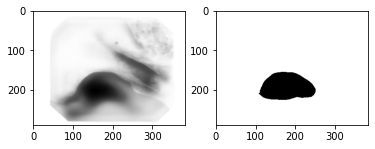

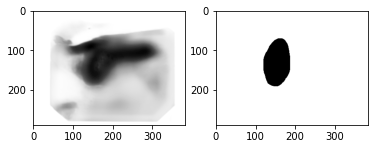

In [ ]:
for batch in present_loader:
  tmp,tmp_mask = batch['image'],batch['mask']
  # print(tmp.size)
  tmp = tmp.to(device=device, dtype=torch.float32)
  tmp_mask = tmp_mask.to(device=device, dtype=torch.float32)
  with torch.no_grad():
    mask_pred = net(tmp)
    pred = torch.sigmoid(mask_pred).cpu()
    tmp_mask=tmp_mask.cpu()
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(pred[ :, :, :].squeeze(), cmap=plt.cm.gray_r)
    plt.subplot(1,2,2)
    plt.imshow(tmp_mask[ :, :, :].squeeze(), cmap=plt.cm.gray_r)
    plt.show()
    